(0.9109844310402617, 0.08901556895973828) (0.9636922004485586, 0.036307799551441367)


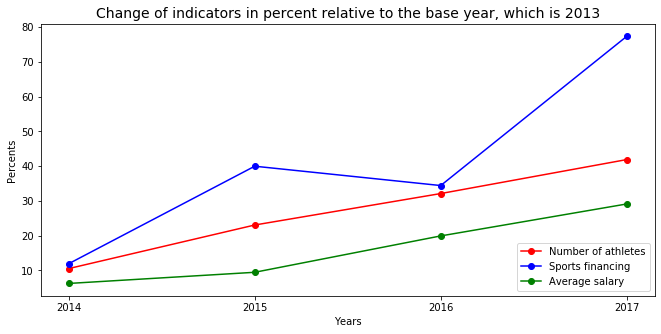

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.ticker as ticker


def make_df(year, old_df=None):
    '''Take year format: 2013 = 13, and DataFrame that has data for years before this year, and return
    united DataFrame'''
    #dict with keys = year, items = file with data on this year
    dict_files = {13: 'pokazrazFKC2013.xls', 14: 'statistikaMassSport2014.xlsx', 15: 'Pokazateli-razvitia-FKC2015.xlsx', 
                  16: 'PokazateliFKS2016.xlsx', 17: 'PokazateliFKS2017.xlsx'} 
    
    english_names = ['State', 'Numbers of athletes {}'.format(year), 
                     'Financing {}'.format(year)] # english names for columns
    df = pd.read_excel(dict_files[year])
    states = df.columns[2] # column with states
    num_of_ath = df.columns[14] # column with number of athletes
    if year == 17: # file with data on 2017 year have one extra column
        num_of_ath = df.columns[15]
    finance = df.columns[-2] # column with financing
    res = pd.DataFrame((df[states], df[num_of_ath], df[finance])).T # result DF
    res.dropna(inplace=True)
    res.columns = english_names
    res = res.set_index(['State']) 
    if type(old_df) == type(df): # check that old_df have df type, and united df with old_df
        res = old_df.merge(res, how='inner', left_index=True, right_index=True) 
    return res


def make_salary_df():
    '''Make DataFrame with average salary data'''
    
    years = ['2013', '2014', '2015', '2016', '2017'] # list with years
    df = pd.read_excel('t2(1).xlsx') 
    res = pd.DataFrame((df[df.columns[0]].str.strip(), df[df.columns[12]], df[df.columns[24]], 
                        df[df.columns[36]], df[df.columns[48]], df[df.columns[60]])).T
    res.dropna(inplace=True)
    res = res.set_index(res.columns[0])
    res.columns = years
    return res


class Cursor(object):
    '''Class that shows mouse position as a percentage'''
    def __init__(self, ax):
        self.ax = ax
        self.txt = ax.text(0.83, 0.12, '', transform=ax.transAxes)
        
    def mouse_move(self, event):
        if not event.inaxes:
            return
        x, y = event.xdata, event.ydata
        self.txt.set_text('Percent = %1.2f' % (y))
        plt.draw()


def percent(ser):
    '''Take Series with data and compute change in percent relative to the base year (2013 year)'''
    res = [] # list with result
    a = ser.iloc[0] # value for the base year
    for i in ser.index[1:]:
        if a > ser[i]: # if value for the base year more than value for the current year - change will be negative
            res.append((a / ser[i] - 1) * -100)
        else:
            res.append((ser[i] / a - 1) * 100)
    return res



  
df = False # may be don't smart, but works :)   
for i in range(13, 18):
    df = make_df(i, df)

mcd = make_salary_df() 
df = df.merge(mcd, how='inner', left_index=True, right_index=True) # df that have all data
finance = df.columns[df.columns.str.match('F')] # It allows us to choose data with financing for all years
athletes = df.columns[df.columns.str.match('N')] # Allows us to choose data with number of athletes for all years
salary = df.columns[df.columns.str.match('2')] # Allows us to choose data with average salary for all years

state = 'Российская Федерация'
# My plot show data for Russian Federation, but if you whant you can choose state of Russia randomly
#state = np.random.choice(df.index)
#print(state)

ath = percent(df.loc[state][athletes]) # normalized athletes data in percent
fin = percent(df.loc[state][finance]) # normalized finance data in percent
sal = percent(df.loc[state][salary]) # normalized salary data in percent

fig, ax = plt.subplots()
ax.set_xlabel('Years')
ax.set_ylabel('Percents')
plt.title('Change of indicators in percent relative to the base year, which is 2013', fontsize=14)
plt.plot(ath, '-o', color='red', label = 'Number of athletes')
plt.plot(fin, '-o', color='blue', label = 'Sports financing')
plt.plot(sal, '-o', color='green', label = 'Average salary')
ax.legend(loc = 'lower right')
fig.set_figheight(5) # size for jupiter
# fig.set_figheight(8) # size that you see in pdf and if you whant open .py file
fig.set_figwidth(11) # size for jupiter
# fig.set_figwidth(14) # size that you see in pdf and if you whant open .py file
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels(salary)


# print(stats.pearsonr(ath, fin), stats.pearsonr(ath, sal)) # if you whant see Pearson correlation
      
cur = Cursor(ax)
plt.connect('motion_notify_event', cur.mouse_move) # I don't know why, but it doesn't works in jupiter.
# If you whant, you can open it like .py file, but difference is not very big
plt.show()